# Classification of White Blood Cell Images using Convolutionary Neural Networks

**Required dataset**

Double-labelled RaabinWBC: https://dl.raabindata.com/WBC/Cropped_double_labeled/

PBC dataset: https://data.mendeley.com/datasets/snkd93bnjr/1

**Required environment**

pytorch 2.2.2

python 3.8

In [14]:
# import libraries
import os
import cv2
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy, multiclass_confusion_matrix, multiclass_precision, multiclass_recall
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import confusion_matrix

## Data Preprocessing

Using OpenCV to transform colored images to grayscale images with addition of embossing, shadow, brightness, halo ring, etc...

In [15]:
# Define function to transform image in each folder and save to a new folder

def transform_images(input_folder, output_folder, bright,highlight,black):
    def transform_image(image):
        # Convert the image to HSV
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Split the HSV image into its components
        h, s, v = cv2.split(hsv_image)

        # Define the embossing kernel
        kernel = np.array([[0, -1, -1],
                           [1, 0, -1],
                           [1, 1, 0]])

        # Apply convolution to the value component
        embossed_v = cv2.filter2D(v, -1, kernel)

        # Invert the colors
        inverted_embossed_v = 255 - embossed_v

        # Add more gray color by blending the smoothed image with the original value component
        blended_v = cv2.addWeighted(v, 1.0, inverted_embossed_v, 0.1, 20)

        # Increase shadow black
        increased_shadow_black_v = cv2.addWeighted(blended_v, 0.7, np.zeros_like(blended_v), 0, black)

        # Increase brightness
        enhance_v = cv2.addWeighted(increased_shadow_black_v, bright , np.zeros_like(increased_shadow_black_v), 0, 10)

        # Create a halo ring
        halo_mask = cv2.GaussianBlur(enhance_v, (0, 0), 10)
        halo_ring = cv2.addWeighted(enhance_v, 1.5, halo_mask, -0.5, 0)

        # Increase highlight
        increased_highlight_v = cv2.addWeighted(halo_ring, 1, np.zeros_like(halo_ring), 0, highlight)


        # Apply Gaussian blur to smooth the image
        smoothed_image = cv2.GaussianBlur(increased_highlight_v, (15, 15), 0)

        return smoothed_image

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through image files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            # Load the image
            img_path = os.path.join(input_folder, filename)
            image = cv2.imread(img_path)

            # Apply transformation
            transformed_image = transform_image(image)

            # Save the transformed image to the output folder
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, transformed_image)

    print("Transformation complete.")

Apply the defined function to transform images in Train, Test A, and PBC

In [17]:
# Transform image in Train dataset
transform_images('./data/RaabinWBC/Train/Basophil', './data/RaabinWBC/Train_gray/Basophil',3,10,-90)
transform_images('./data/RaabinWBC/Train/Eosinophil', './data/RaabinWBC/Train_gray/Eosinophil',2.4,15,-100)
transform_images('./data/RaabinWBC/Train/Lymphocyte', './data/RaabinWBC/Train_gray/Lymphocyte',2.4,15,-100)
transform_images('./data/RaabinWBC/Train/Monocyte', './data/RaabinWBC/Train_gray/Monocyte',2.3,15,-100)
transform_images('./data/RaabinWBC/Train/Neutrophil', './data/RaabinWBC/Train_gray/Neutrophil',2.3,15,-80)
# Transform image in TestA dataset
transform_images('./data/RaabinWBC/TestA/Lymphocyte', './data/RaabinWBC/TestA_gray/Lymphocyte',2.4,15,-100)
transform_images('./data/RaabinWBC/TestA/Neutrophil', './data/RaabinWBC/TestA_gray/Neutrophil',2.3,15,-80)
transform_images('./data/RaabinWBC/TestA/Basophil', './data/RaabinWBC/TestA_gray/Basophil',3,10,-90)
transform_images('./data/RaabinWBC/TestA/Eosinophil', './data/RaabinWBC/TestA_gray/Eosinophil',2.4,15,-100)
transform_images('./data/RaabinWBC/TestA/Monocyte', './data/RaabinWBC/TestA_gray/Monocyte',2.3,15,-100)
# Transform image in PBC dataset
transform_images('./data/PBC/Lymphocyte', './data/RaabinWBC/PBC_gray/Lymphocyte',2.4,15,-100)
transform_images('./data/PBC/Neutrophil', './data/RaabinWBC/PBC_gray/Neutrophil',2.3,15,-80)
transform_images('./data/PBC/Basophil', './data/RaabinWBC/PBC_gray/Basophil',3,10,-90)
transform_images('./data/PBC/Eosinophil', './data/RaabinWBC/PBC_gray/Eosinophil',2.4,15,-100)
transform_images('./data/PBC/Monocyte', './data/RaabinWBC/PBC_gray/Monocyte',2.3,15,-100)

Transformation complete.
Transformation complete.
Transformation complete.
Transformation complete.
Transformation complete.
Transformation complete.
Transformation complete.
Transformation complete.
Transformation complete.
Transformation complete.
Transformation complete.
Transformation complete.
Transformation complete.
Transformation complete.
Transformation complete.


## Loading Images

Use GPU for robusting training if possible.

In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Define the transformation for loading colored and grayscale images

In [7]:
# Define transform for grayscale images
gray_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])
# Define transform for colored images
color_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Specify the root folders for grayscale and colored datasets
grayscale_root = './data/RaabinWBC/Train_gray'
colored_root = './data/RaabinWBC/Train'

Load colored images and grayscales from their subfolders. Split the data into training and testing sets.

In [7]:
# Load each subfolder as an ImageFolder dataset
grayscale_dataset = ImageFolder(root=grayscale_root, transform=gray_transform)
colored_dataset = ImageFolder(root=colored_root, transform=color_transform)

# Specify the ratio for train and validation sets
train_ratio = 0.8  # 80% for training set # 20% for validation set
train_size = int(train_ratio * len(grayscale_dataset))
valid_size = len(grayscale_dataset) - train_size

# Randomly split the dataset into training and validation sets
train_gray_dataset, valid_gray_dataset = random_split(grayscale_dataset, [train_size, valid_size])
train_color_dataset, valid_color_dataset = random_split(colored_dataset, [train_size, valid_size])

# Assign the classes to the training and validation datasets
classes = grayscale_dataset.classes
train_gray_dataset.dataset.classes = classes
valid_gray_dataset.dataset.classes = classes
train_color_dataset.dataset.classes = classes
valid_color_dataset.dataset.classes = classes

# Create DataLoader for train and validation datasets
batch_size = 32
train_gray_loader = DataLoader(train_gray_dataset, batch_size=batch_size, shuffle=True)
valid_gray_loader = DataLoader(valid_gray_dataset, batch_size=batch_size, shuffle=False)
train_color_loader = DataLoader(train_color_dataset, batch_size=batch_size, shuffle=True)
valid_color_loader = DataLoader(valid_color_dataset, batch_size=batch_size, shuffle=False)

Check the name of classes in grayscale and colored datasets

In [10]:
grayscale_dataset.classes

['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']

In [11]:
colored_dataset.classes

['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']

## Weight Cross Entropy Loss Function

Define function to calculate weight for weighted loss function

In [12]:
# Define function for calculate weights
def calculate_class_weights(loader):
    class_counts = torch.zeros(len(loader.dataset.dataset.classes))
    total_samples = 0
    for _, labels in loader:
        class_counts += torch.bincount(labels, minlength=len(loader.dataset.dataset.classes))
        total_samples += len(labels)
    class_weights = total_samples / (class_counts * len(loader.dataset.dataset.classes))
    return class_weights

Define the CNN model

In [13]:
# Define the model (pretrained ResNet-18)
model = models.resnet18(weights="DEFAULT") # pretrained = True
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_gray_dataset.dataset.classes))

Calculate weight and assign to a criterion CrossEntropyLoss. Define optimizer.

In [14]:
# Define loss function and optimizer with weighted loss
class_weights = calculate_class_weights(train_gray_loader)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Show weights of each class that we added to the model.

In [15]:
class_weights

tensor([9.1977, 2.7454, 0.8532, 3.6178, 0.3248])

## Model Training

The model will be fine-tuned with color images for 10 epochs then grayscale images for 20 epochs.

In [16]:
# Initialize empty lists to store loss values
train_gray_losses = []
valid_gray_losses = []
train_color_losses = []
valid_color_losses = []

# Training with color images
epochs = 10
min_valid_loss = np.inf

for e in range(epochs):
    train_color_loss = 0.0
    model.train()
    for inputs, labels in train_color_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_color_loss += loss.item() * inputs.size(0)
    
    valid_color_loss = 0.0
    model.eval()
    for inputs, labels in valid_color_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        valid_color_loss += loss.item() * inputs.size(0)
 
    # Calculate average losses
    train_color_loss /= len(train_color_loader.dataset)
    valid_color_loss /= len(valid_color_loader.dataset)
    
    # Append losses to lists
    train_color_losses.append(train_color_loss)
    valid_color_losses.append(valid_color_loss)
 
    print(f'Epoch {e+1} \t\t Training Loss: {train_color_loss} \t\t Validation Loss: {valid_color_loss}')
    
    if min_valid_loss > valid_color_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_color_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_color_loss
        torch.save(model.state_dict(), 'wbc_model_color.pth')

Epoch 1 		 Training Loss: 0.35941458065474646 		 Validation Loss: 0.1341958547180349
Validation Loss Decreased(inf--->0.134196) 	 Saving The Model
Epoch 2 		 Training Loss: 0.08464010902463072 		 Validation Loss: 0.1059327224127637
Validation Loss Decreased(0.134196--->0.105933) 	 Saving The Model
Epoch 3 		 Training Loss: 0.06437055621049036 		 Validation Loss: 0.07933092971655016
Validation Loss Decreased(0.105933--->0.079331) 	 Saving The Model
Epoch 4 		 Training Loss: 0.06165306323576325 		 Validation Loss: 0.10429259629448744
Epoch 5 		 Training Loss: 0.04559943732743767 		 Validation Loss: 0.0905550321028625
Epoch 6 		 Training Loss: 0.03508191600817208 		 Validation Loss: 0.09067227332795574
Epoch 7 		 Training Loss: 0.028999285732169408 		 Validation Loss: 0.10024815968830478
Epoch 8 		 Training Loss: 0.028300432064993816 		 Validation Loss: 0.09263291535721703
Epoch 9 		 Training Loss: 0.02595732360140075 		 Validation Loss: 0.10361324545151625
Epoch 10 		 Training Loss: 0.01

In [17]:
# Train with grayscale images
model.fc = nn.Linear(num_ftrs, len(train_gray_dataset.dataset.classes))
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

epochs = 20
min_valid_loss = np.inf

for e in range(epochs):
    train_gray_loss = 0.0
    model.train()
    for inputs, labels in train_gray_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_gray_loss += loss.item() * inputs.size(0)
    
    valid_gray_loss = 0.0
    model.eval()
    for inputs, labels in valid_gray_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        valid_gray_loss += loss.item() * inputs.size(0)
 
    # Calculate average losses
    train_gray_loss /= len(train_gray_loader.dataset)
    valid_gray_loss /= len(valid_gray_loader.dataset)
    
    # Append losses to lists
    train_gray_losses.append(train_gray_loss)
    valid_gray_losses.append(valid_gray_loss)
 
    print(f'Epoch {e+1} \t\t Training Loss: {train_gray_loss} \t\t Validation Loss: {valid_gray_loss}')
    
    if min_valid_loss > valid_gray_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_gray_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_gray_loss
        torch.save(model.state_dict(), 'wbc_model_gray.pth')

Epoch 1 		 Training Loss: 0.32059678621818966 		 Validation Loss: 0.15145239184544185
Validation Loss Decreased(inf--->0.151452) 	 Saving The Model
Epoch 2 		 Training Loss: 0.10573482167625603 		 Validation Loss: 0.06145997422104312
Validation Loss Decreased(0.151452--->0.061460) 	 Saving The Model
Epoch 3 		 Training Loss: 0.0613046149262147 		 Validation Loss: 0.07397948205379508
Epoch 4 		 Training Loss: 0.05004144496300443 		 Validation Loss: 0.0655058226161419
Epoch 5 		 Training Loss: 0.037333864239141736 		 Validation Loss: 0.07473334308590109
Epoch 6 		 Training Loss: 0.025636068610840588 		 Validation Loss: 0.10186167251437683
Epoch 7 		 Training Loss: 0.026294185091221948 		 Validation Loss: 0.05946446774294028
Validation Loss Decreased(0.061460--->0.059464) 	 Saving The Model
Epoch 8 		 Training Loss: 0.021513759391439544 		 Validation Loss: 0.06767096088928026
Epoch 9 		 Training Loss: 0.016417498514571065 		 Validation Loss: 0.04884234895192874
Validation Loss Decreased(0

Plot the learning curve to examine overfitting

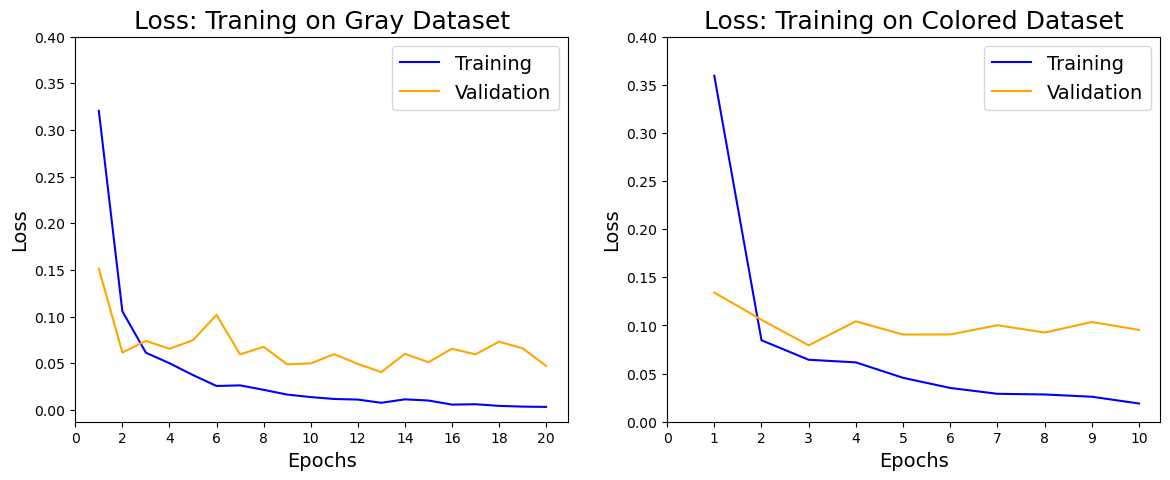

In [14]:
plt.figure(figsize=(14, 5)) 

# Plotting the loss curve for the gray dataset
plt.subplot(1, 2, 1)
epochs = range(1, len(train_gray_losses) + 1)
plt.plot(epochs, train_gray_losses, 'b', label='Training')
plt.plot(epochs, valid_gray_losses, 'orange', label='Validation')
plt.title('Loss: Traning on Gray Dataset', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(range(0, 22, 2))
plt.yticks([i / 100 for i in range(0, 41, 5)])

# Plotting the loss curve for the colored dataset
plt.subplot(1, 2, 2)
epochs = range(1, len(train_color_losses) + 1)
plt.plot(epochs, train_color_losses,'b', label='Training')
plt.plot(epochs, valid_color_losses,'orange', label='Validation')
plt.title('Loss: Training on Colored Dataset', fontsize=18)
plt.xlabel('Epochs', fontsize=14) 
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(range(0, 11))
plt.yticks([i / 100 for i in range(0, 41, 5)])
plt.show()

## Model Testing

Load the saved model

In [3]:
# Define function to load the saved model
def load_model(model_path, num_classes):
    model = models.resnet18(weights=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

import os
from PIL import Image
import torch

# Define function to make predictions on images in a folder
def predict_folder(model, folder_path, transform):
    predictions = []
    true_labels = []
    image_paths = []
    label_to_class = sorted(os.listdir(folder_path))
    
    for label in label_to_class:
        subfolder_path = os.path.join(folder_path, label)
        if os.path.isdir(subfolder_path):
            label_index = label_to_class.index(label)
            print(f"Label index: {label_index}, Folder name: {label}")
            for image_name in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_name)
                image = transform(Image.open(image_path).convert('RGB'))
                image = torch.unsqueeze(image, 0)
                with torch.no_grad():
                    output = model(image)
                    _, predicted = torch.max(output, 1)
                    predictions.append(predicted.item())
                    true_labels.append(label_index)
                    image_paths.append(image_path)
    
    return predictions, true_labels, image_paths

In [4]:
# Load the saved model
model_path = "wbc_model_gray.pth"
num_classes = 5
model = load_model(model_path, num_classes)

test_gray_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

/Users/tiennguyen/anaconda3/envs/img_torch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Evaluation using Test A

Set the path to Test A folder. Predict the classes and stored predicted results, true labels, and image paths in separate variables.

In [23]:
test_folder_path = "./data/RaabinWBC/TestA_gray"
predictions, true_labels, image_paths = predict_folder(model, test_folder_path, test_gray_transform)

Label index: 0, Folder name: Basophil
Label index: 1, Folder name: Eosinophil
Label index: 2, Folder name: Lymphocyte
Label index: 3, Folder name: Monocyte
Label index: 4, Folder name: Neutrophil


Save the prediction results for further analysis

In [24]:
# Export prediction results to CSV file
results_df = pd.DataFrame({
    'Image_Path': image_paths,
    'True_Label': true_labels,
    'Predicted_Label': predictions
})
results_df.to_csv("pred_Raabin_TestA_gray.csv", index=False)

Convert the prediction and true label to tensor

In [26]:
input = torch.tensor(predictions)
target = torch.tensor(true_labels)

F1-score

In [27]:
print("F1_score_overall:",multiclass_f1_score(input, target, num_classes=5, average="macro"))

F1_score_overall: tensor(0.9962)


In [28]:
print("F1_score_classes:",multiclass_f1_score(input, target, num_classes=5, average=None))

F1_score_classes: tensor([1.0000, 0.9906, 0.9966, 0.9936, 1.0000])


Accuracy score

In [29]:
print("Accuracy_overall:",multiclass_accuracy(input, target, num_classes=5, average="macro"))

Accuracy_overall: tensor(0.9950)


/Users/tiennguyen/anaconda3/envs/img_torch/lib/python3.8/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403248303/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:235.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


In [30]:
print("Accuracy_classes:",multiclass_accuracy(input, target, num_classes=5, average=None))

Accuracy_classes: tensor([1.0000, 0.9845, 0.9990, 0.9915, 1.0000])


Precision score

In [31]:
print("Precision_overall:",multiclass_precision(input, target, num_classes=5, average="macro"))

Precision_overall: tensor(0.9974)


In [32]:
print("Precision_classes:",multiclass_precision(input, target, num_classes=5, average=None))

Precision_classes: tensor([1.0000, 0.9969, 0.9942, 0.9957, 1.0000])


Recall score

In [33]:
print("Recall_overall:",multiclass_recall(input, target, num_classes=5, average="macro"))

Recall_overall: tensor(0.9950)


In [34]:
print("Recall_classes:",multiclass_recall(input, target, num_classes=5, average=None))

Recall_classes: tensor([1.0000, 0.9845, 0.9990, 0.9915, 1.0000])


Confusion matrix

In [35]:
conf_matrix = multiclass_confusion_matrix(input,target,num_classes=5)
conf_matrix

tensor([[  89,    0,    0,    0,    0],
        [   0,  317,    4,    1,    0],
        [   0,    1, 1033,    0,    0],
        [   0,    0,    2,  232,    0],
        [   0,    0,    0,    0, 2660]])

Define function to visualize confusion matrix as percentage. Source code: https://gist.github.com/liuhengyue/61aea55b5886181981b536865fd5341c

In [156]:
def cm_analysis(y_true, y_pred,labels, classes, ymap=None):
    sns.set(font_scale=1.8)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d' % (p, c)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'TRUE LABEL'
    cm.columns.name = 'PREDICTED LABEL'
    fig, ax = plt.subplots(figsize=(15,15))
    plt.yticks(va='center')
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=False, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues", square=True)
    plt.show()

Visualize the confusion matrix

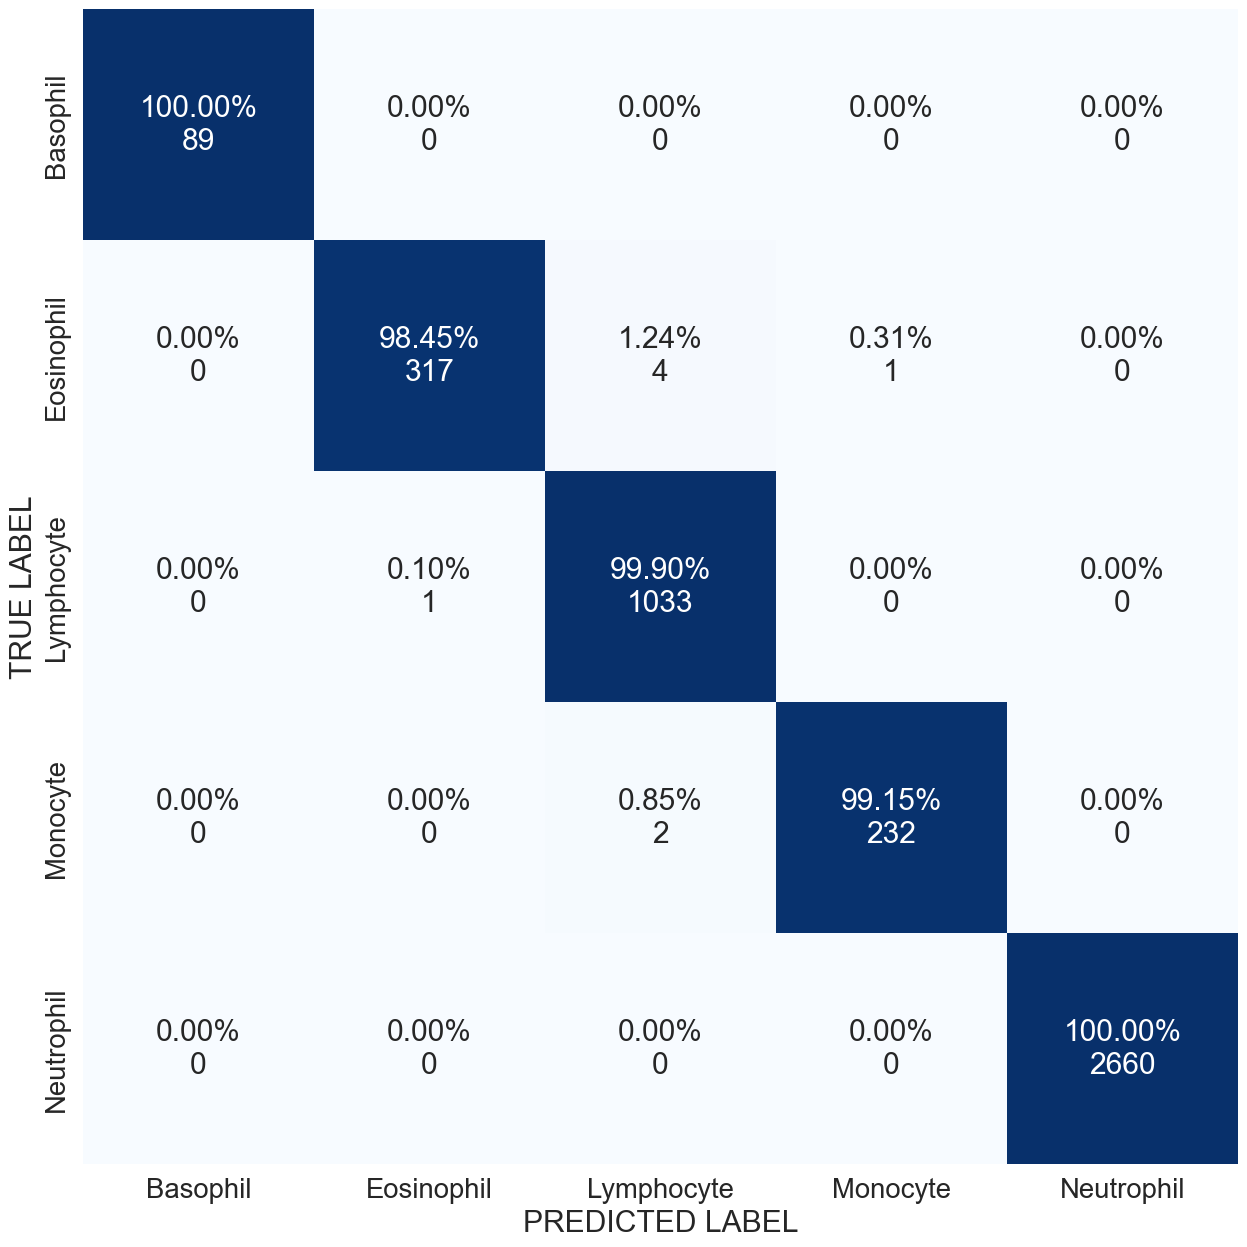

In [157]:
cm_analysis(true_labels, predictions,labels=[0,1,2,3,4], classes=colored_dataset.classes, ymap=None)

### Evaluation using PBC dataset

Set path to PBC folder. Predict and store the prediction results in separate variable.

In [51]:
test_folder_path_2 = "./data/RaabinWBC/PBC_gray"
predictions_2, true_labels_2, image_paths_2 = predict_folder(model, test_folder_path_2, test_gray_transform)

Label index: 0, Folder name: Basophil
Label index: 1, Folder name: Eosinophil
Label index: 2, Folder name: Lymphocyte
Label index: 3, Folder name: Monocyte
Label index: 4, Folder name: Neutrophil


Save the predicted result in csv file for further analysis

In [52]:
# Export prediction results to CSV file
results_df_2 = pd.DataFrame({
    'Image_Path': image_paths_2,
    'True_Label': true_labels_2,
    'Predicted_Label': predictions_2
})
results_df_2.to_csv("pred_Raabin_PBC_gray.csv", index=False)

Convert prediction and true label to tensor

In [53]:
input_2 = torch.tensor(predictions_2)
target_2 = torch.tensor(true_labels_2)

F1 score

In [54]:
print("F1_score_overall:",multiclass_f1_score(input_2, target_2, num_classes=5, average="macro"))

F1_score_overall: tensor(0.8462)


In [55]:
print("F1_score_classes:",multiclass_f1_score(input_2, target_2, num_classes=5, average=None))

F1_score_classes: tensor([0.9081, 0.7571, 0.6596, 0.9405, 0.9656])


Accuracy score

In [56]:
print("Accuracy_overall:",multiclass_accuracy(input_2, target_2, num_classes=5, average="macro"))

Accuracy_overall: tensor(0.8721)


In [57]:
print("Accuracy_classes:",multiclass_accuracy(input_2, target_2, num_classes=5, average=None))

Accuracy_classes: tensor([0.8358, 0.6099, 0.9992, 0.9176, 0.9982])


Precision score

In [58]:
print("Precision_overall:",multiclass_precision(input_2, target_2, num_classes=5, average="macro"))

Precision_overall: tensor(0.8768)


In [59]:
print("Precision_classes:",multiclass_precision(input_2, target_2, num_classes=5, average=None))

Precision_classes: tensor([0.9941, 0.9979, 0.4923, 0.9645, 0.9350])


Recall score

In [60]:
print("Recall_overall:",multiclass_recall(input_2, target_2, num_classes=5, average="macro"))

Recall_overall: tensor(0.8721)


In [61]:
print("Recall_classes:",multiclass_recall(input_2, target_2, num_classes=5, average=None))

Recall_classes: tensor([0.8358, 0.6099, 0.9992, 0.9176, 0.9982])


Confusion matrix

In [62]:
conf_matrix_2 = multiclass_confusion_matrix(input_2,target_2,num_classes=5)
conf_matrix_2

tensor([[1018,    0,    0,    0,  200],
        [   0, 1901, 1137,   48,   31],
        [   0,    1, 1213,    0,    0],
        [   0,    3,  114, 1303,    0],
        [   6,    0,    0,    0, 3323]])

Plot confusion matrix

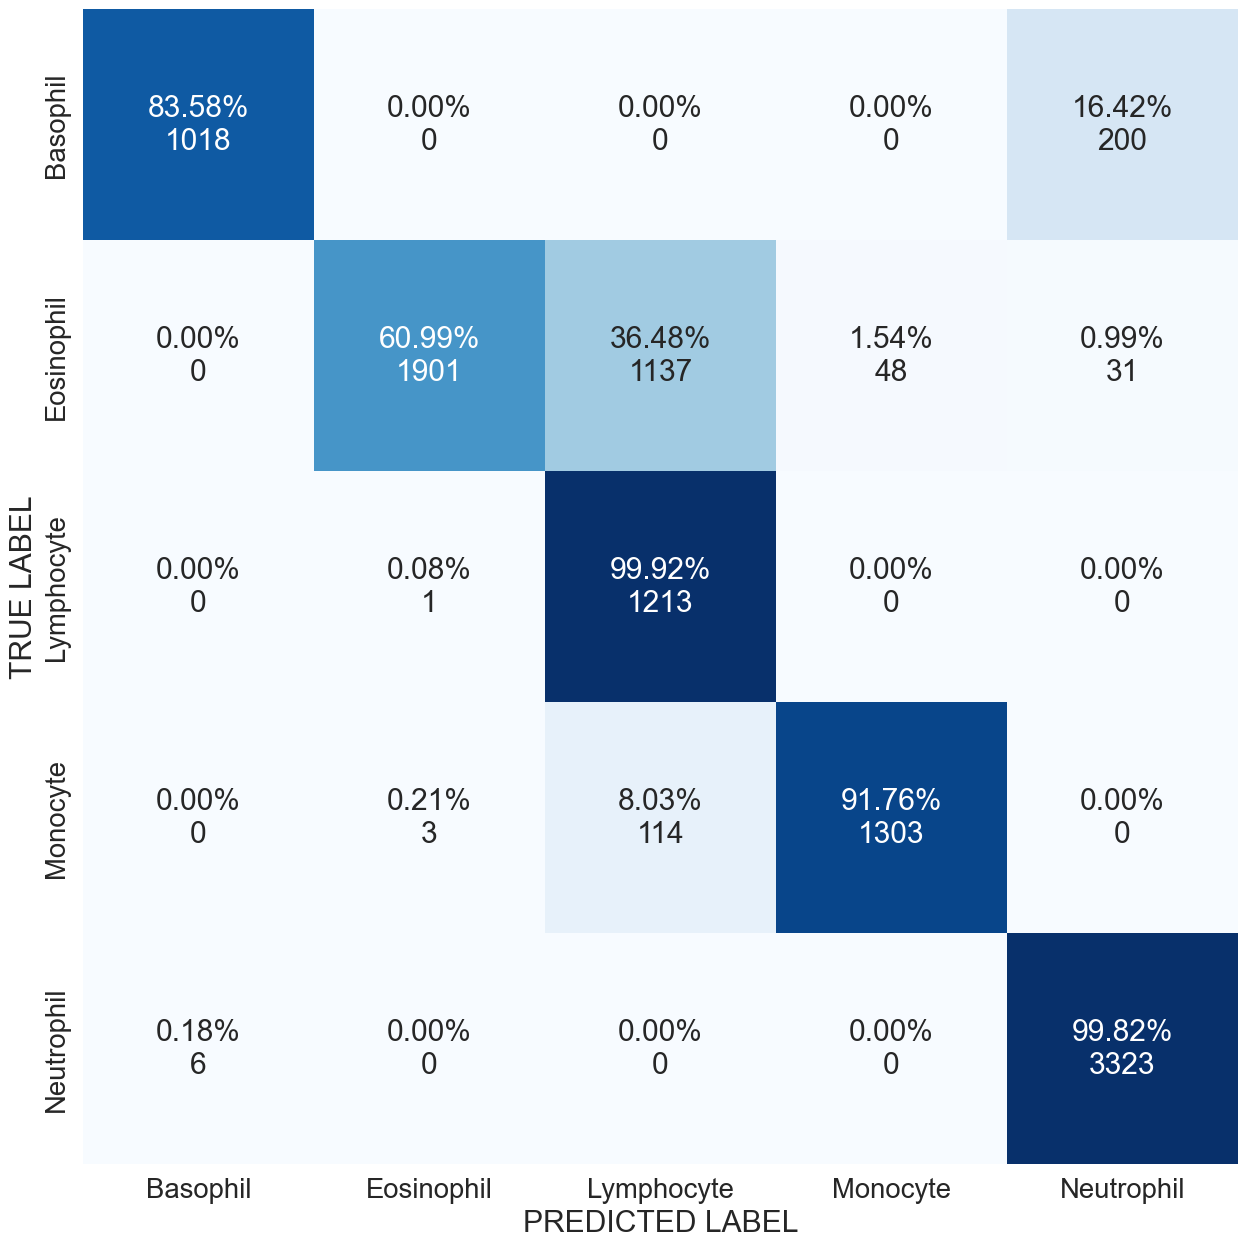

In [158]:
# Plot confusion matrix
cm_analysis(true_labels_2, predictions_2,labels=[0,1,2,3,4], classes=colored_dataset.classes, ymap=None)

## Demo

In [18]:
test_folder_path = "./data/Demo"
predictions_3, true_labels_3, image_paths_3 = predict_folder(model, test_folder_path, test_gray_transform)

Label index: 0, Folder name: Basophil
Label index: 1, Folder name: Eosinophil
Label index: 2, Folder name: Lymphocyte
Label index: 3, Folder name: Monocyte
Label index: 4, Folder name: Neutrophil


In [19]:
print (predictions_3, true_labels_3)

[0, 1, 2, 2, 4] [0, 1, 2, 3, 4]


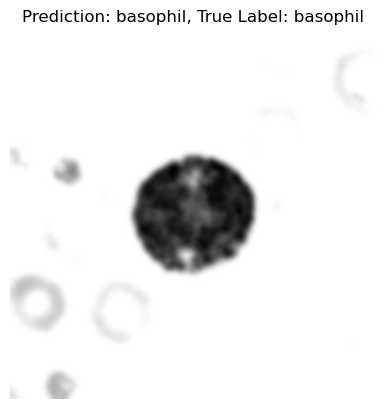

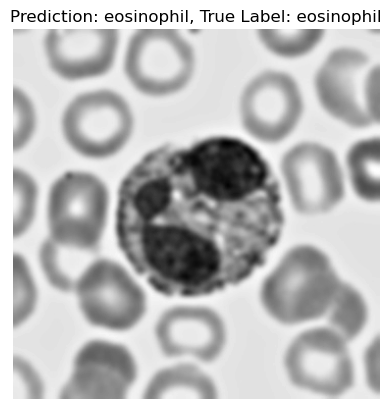

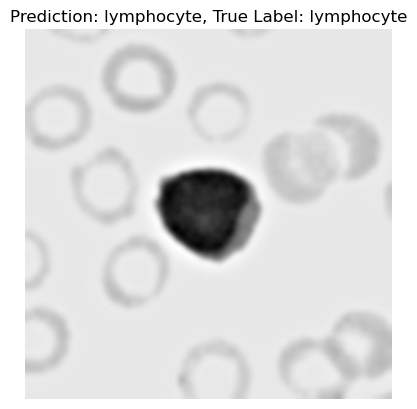

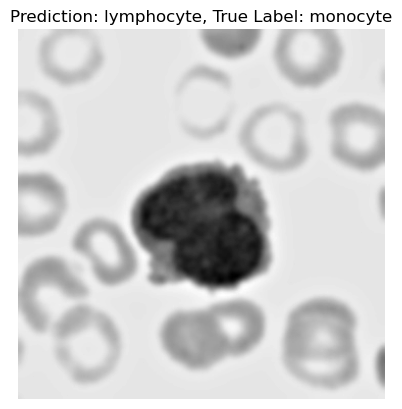

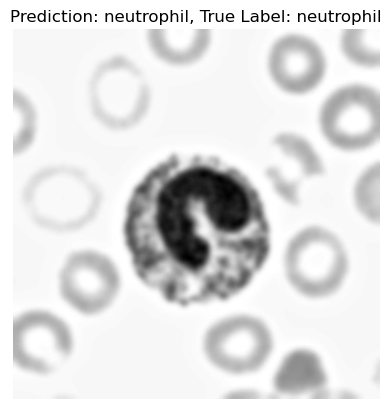

In [20]:
# Define labels dictionary
labels_dict = {
    0: "basophil",
    1: "eosinophil",
    2: "lymphocyte",
    3: "monocyte",
    4: "neutrophil"
}

# Visualize predictions
for i in range(len(predictions_3)):
    image_path = image_paths_3[i]
    prediction = predictions_3[i]
    true_label = true_labels_3[i]
    
    # Load and display the image
    image = Image.open(image_path)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    # Display prediction and true label
    plt.title(f'Prediction: {labels_dict[prediction]}, True Label: {labels_dict[true_label]}')
    plt.show()